<a href="https://colab.research.google.com/github/nicolaiberk/llm_ws/blob/main/notebooks/02_embeddings_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to embedding manipulation with `gensim`

In [ ]:
!pip install gensim # restart after installation

## Word Embeddings from Pre-Trained Models

In [ ]:
## we load a 100-dimensional GloVe model trained on Wikipedia data
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') # small model so we don't have to wait too long...

In [ ]:
wv['ziti'] # what do our embeddings look like?

array([ 0.049439 ,  0.33049  , -0.62916  ,  0.05941  , -0.070866 ,
       -0.31198  ,  1.0051   , -0.36994  ,  0.51071  ,  0.88759  ,
        0.30675  ,  0.41871  , -0.20705  ,  0.54854  ,  0.2315   ,
       -0.10115  , -0.44656  ,  0.022504 ,  0.31798  ,  0.44769  ,
       -0.50513  ,  0.34741  , -0.069257 ,  0.22331  ,  0.41969  ,
        0.27958  ,  0.0037731, -0.22206  , -0.60191  , -0.67105  ,
        0.1164   ,  0.099292 ,  0.16863  , -0.69876  ,  0.13203  ,
        0.14845  ,  0.020125 , -0.40887  ,  0.15019  , -0.25258  ,
        0.69223  , -0.24897  ,  0.047037 , -0.33101  , -0.16142  ,
        0.10763  , -0.06854  , -0.29817  ,  0.15847  ,  0.92439  ,
        0.52995  ,  0.89365  ,  0.56876  , -0.2421   , -0.78985  ,
        0.75897  ,  0.53027  ,  0.53722  , -0.94077  ,  0.0013162,
       -0.12927  , -0.10485  , -0.059788 , -0.56039  , -0.38289  ,
       -0.43905  ,  0.02313  , -0.27358  , -0.086559 , -0.54393  ,
       -0.49323  ,  0.14044  ,  0.50186  ,  0.11039  , -0.4033

### Get most similar words

In [ ]:
## so what are 'ziti' according to our model? Let's check the most similar embeddings:
print(wv.most_similar(positive=['ziti'], topn=5))

[('rigatoni', 0.7073922753334045), ('penne', 0.6969300508499146), ('focaccia', 0.6311710476875305), ('rotini', 0.626558780670166), ('scrod', 0.6251025199890137)]


In [ ]:
## you can assess the similarity to other words with the `similarity` function (we'll cover what this score is later today)
wv.similarity('ziti', 'penne')

0.69693005

In [ ]:
# Whereas
wv.similarity('ziti', 'banana')

0.15077046

In [ ]:
# and
wv.similarity('ziti', 'car')

-0.2821738

In [ ]:
## You can calculate with these embeddings:
wv_london = wv['paris'] - wv['france'] + wv['england']
print(wv.most_similar(positive=[wv_london], topn=5))

[('london', 0.7929531931877136), ('england', 0.7346791625022888), ('melbourne', 0.7304184436798096), ('sydney', 0.7011193037033081), ('perth', 0.6856114268302917)]


In [ ]:
## Though it does not always work perfectly
wv_queen = wv['king'] + wv['woman'] - wv['man']
print(wv.most_similar(positive=[wv_queen], topn=5))

[('king', 0.8551837205886841), ('queen', 0.783441424369812), ('monarch', 0.6933802366256714), ('throne', 0.6833109259605408), ('daughter', 0.680908203125)]


In [ ]:
## you can also use the inbuilt function to get weighted averages
print(wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=5))

[('queen', 0.7698541283607483), ('monarch', 0.6843380331993103), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991)]


In [ ]:
## other cute functions
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


### Training your own Model

We'll use an adapted dataset of dialogue in the Simpsons from [Kaggle](https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset?resource=download&select=simpsons_script_lines.csv).

![](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3cHA1dDZ5MWUwOWIyMmd3dHk3MGNyNGdvamEzc2w2dzVjdzdvMW5wOCZlcD12MV9naWZzX3NlYXJjaCZjdD1n/tkYpAbKdWj4TS/giphy.gif)

In [ ]:
## load data
import pandas as pd
dataset = pd.read_csv('https://www.dropbox.com/scl/fi/n5ffxvm4qyjkp8ws7qgoq/simpsons_script_lines_clean.csv?rlkey=gfliitwgi8cqsjxlcdmmdwtym&dl=1')
dataset.head()

,id,raw_character_text,spoken_words
0,9549,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,9550,Lisa Simpson,Where's Mr. Bergstrom?
2,9551,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,9552,Lisa Simpson,That life is worth living.
4,9553,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
## clean the texts (very rough here)
dataset['cleaned_text'] = dataset['spoken_words'].str.replace('[^a-zA-Z ]','', regex=True) # remove anything that is not a letter or whitespace
dataset['cleaned_text'] = dataset['cleaned_text'].str.lower() # lowercase
dataset['cleaned_text'] = dataset['cleaned_text'].str.replace(' +', ' ', regex=True) # remove multiple whitespaces

In [ ]:
dataset.cleaned_text.head()

0    no actually it was a little of both sometimes ...
1                                  wheres mr bergstrom
2    i dont know although id sure like to talk to h...
3                            that life is worth living
4    the polls will be open from now until the end ...
Name: cleaned_text, dtype: object

In [ ]:
## filter empty rows and enforce string
dataset = dataset[dataset['cleaned_text'] != '']
dataset.loc[:,'cleaned_text'] = dataset['cleaned_text'].astype(str)

In [ ]:
## how many texts are left?
dataset.shape

(158239, 4)

In [ ]:
## create a list of lists of words by splitting along whitespaces
sentences = [s.split(" ") for s in dataset['cleaned_text']]

In [ ]:
sentences[1]

['wheres', 'mr', 'bergstrom']

In [ ]:
## load dataset (use an iterator for larger datasets: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model)
from gensim.models import Word2Vec

## estimate a model and save
model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # number of dimensions of word embeddings
    window=5,         # number of context words in either direction to include
    min_count=5,      # how often must a word appear to enter the corpus?
    workers=4         # how many CPUs should be used to fit the model?
    )
model.save("simpsons.w2v.model")

In [ ]:
## what is the main output?
model.wv.vectors.shape

(11697, 100)

In [ ]:
## assess model
model.wv.most_similar('homer', topn=5)

[('bart', 0.8320638537406921),
 ('marge', 0.8216521739959717),
 ('lisa', 0.7847773432731628),
 ('abe', 0.7300679683685303),
 ('grampa', 0.7199990153312683)]

In [ ]:
## subset words of interest
interesting_words = [
    'banana', 'pineapple', 'mango',
    'car', 'bike', 'motorcycle',
    'bart', 'lisa', 'homer']
interesting_vecs = wv[interesting_words]

In [ ]:
## dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(interesting_vecs)
wv_2d = pca.transform(interesting_vecs)
wv_2d = pd.DataFrame(wv_2d, index = interesting_words)

In [ ]:
wv_2d

,0,1
banana,3.541009,1.041963
pineapple,4.103635,1.062510
mango,3.847255,0.803716
car,-3.141654,2.390038
bike,-2.633529,1.914495
motorcycle,-2.883575,2.724190
bart,-1.347623,-3.186925
lisa,0.255806,-3.397163
homer,-1.741323,-3.352823


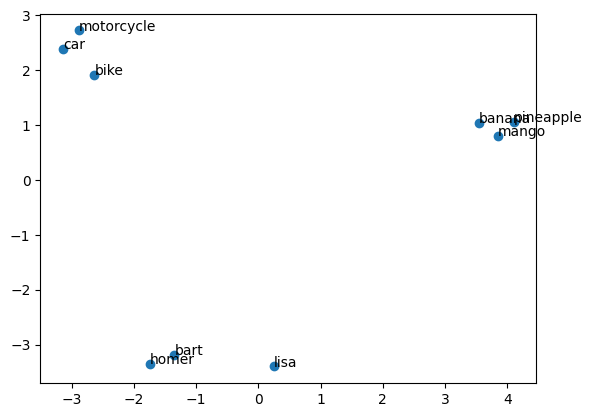

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

In [ ]:
## subset words of interest
interesting_words = [
    'paris', 'berlin', 'france', 'germany']
interesting_vecs = wv[interesting_words]

In [ ]:
## dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(interesting_vecs)
wv_2d = pca.transform(interesting_vecs)
wv_2d = pd.DataFrame(wv_2d, index = interesting_words)

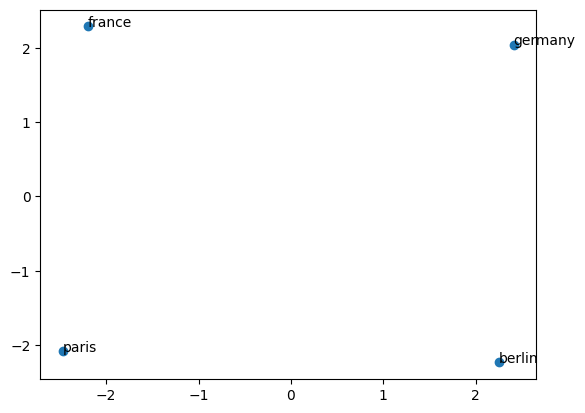

In [ ]:
import matplotlib.pyplot as plt
import random

random.seed(0)

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

## Exercise

1) Calculate the word vector for Berlin from the vectors for 'paris', 'france', and 'germany'. Explain your reasoning. What does the

In [ ]:
## your answer

2) Assess the most similar words to this vector.

In [ ]:
## your answer

3) Plot the calculated vector into the same vector space alongside paris, france, germany, and berlin using PCA.

In [ ]:
## your answer

4) We have trained these embeddings on a dataset from the simpsons, a popular cartoon series. What consequences might this choice of data have for the word embeddings? How might this compare to a corpus trained on Wikipedia data?

**Your answer**

5) Try to find an interesting bias in the data by looking at word similarities

In [ ]:
## your answer